In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ananthu017/emotion-detection-fer

/bin/bash: /home/timmy/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/timmy/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/timmy/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/timmy/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
chmod: cannot access '/root/.kaggle/kaggle.json': Permission denied
/bin/bash: /home/timmy/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|█████████████████████████████████████▉| 65.0M/65.2M [00:11<00:00, 6.31MB/s]
100%|██████████████████████████████████████| 65.2M/65.2M [00:12<00:00, 5.69MB/s]


In [3]:
!unzip -q emotion-detection-fer.zip

/bin/bash: /home/timmy/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
!pip install -q tensorflow_addons

/bin/bash: /home/timmy/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
import numpy as np

2023-01-08 17:54:14.187654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 17:54:14.917765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/timmy/anaconda3/lib/
2023-01-08 17:54:14.917835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/timmy/anaconda3/lib/
2023-01-08 17:54:14.917842: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [6]:
train_dir = 'train'
test_dir = 'test'
BATCH_SIZE = 32
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

train_data = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE,
                                          image_size=(IMG_SIZE, IMG_SIZE), label_mode='categorical',
                                          seed=123)

val_data = image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE,
                                        image_size=(IMG_SIZE, IMG_SIZE), label_mode='categorical',
                                        seed=123)

class_names = train_data.class_names
print(class_names)

Found 28709 files belonging to 7 classes.


2023-01-08 17:54:27.121823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:54:27.263862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:54:27.264057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 17:54:27.388236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Found 7178 files belonging to 7 classes.
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [7]:
for image, label in train_data.take(1):
    print(np.argmax(label[1]))

5


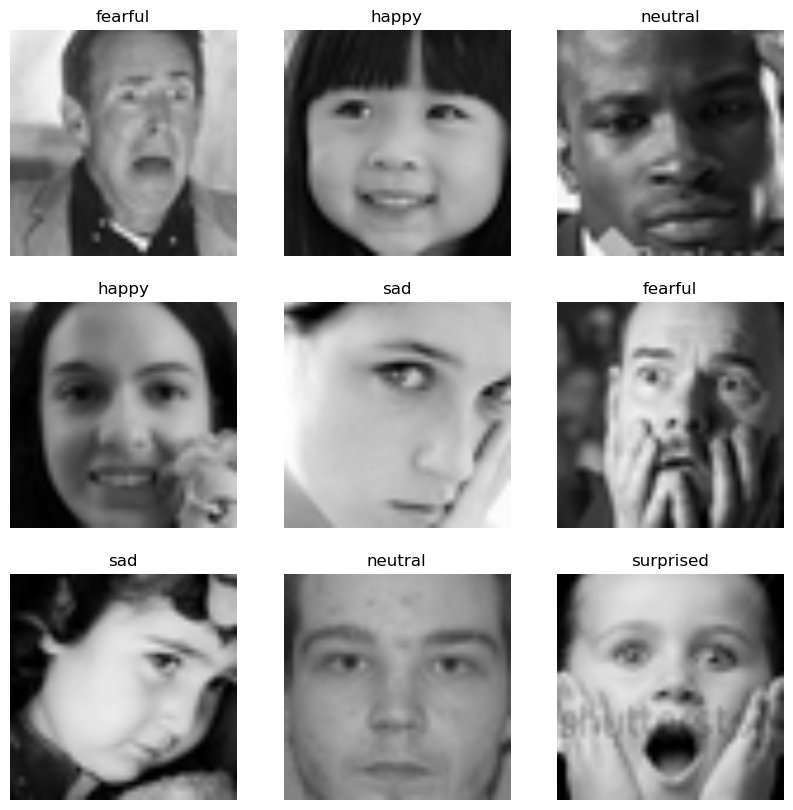

In [8]:
plt.figure(figsize=(10, 10))
for image, label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis('off')

In [9]:
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 5)
val_data = val_data.skip(val_batches // 5)

In [10]:
print('num of val batches %d' % tf.data.experimental.cardinality(val_data))
print('num of test batches %d' % tf.data.experimental.cardinality(test_data))

num of val batches 180
num of test batches 45


In [11]:
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [12]:
print('num of train batches %d' % tf.data.experimental.cardinality(train_data))

num of train batches 898


In [13]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

base_model = tf.keras.applications.efficientnet.EfficientNetB3(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                       weights='imagenet', include_top=False)
image_batch, label_batch = next(iter(train_data))
# print(label_batch[0])

feature_batch = base_model(image_batch)
# print(feature_batch.shape)

base_model.trainable = False
# print(base_model.summary())

global_average_layer = tf.keras.layers.GlobalAvgPool2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(7, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 1e-4


43941136/43941136 [==============================] - 9s 0us/step


2023-01-08 17:55:49.072548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


In [ ]:
label_batch[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)>

In [ ]:
f1_score = tfa.metrics.F1Score(num_classes=7, average=None)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_score])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 7)                 10759     
                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
save_dir = '/content/sample_data/face_emotion'
call_back = ModelCheckpoint(os.path.join(save_dir, 'model', 'model.h5'), monitor='val_loss',
                            save_best_only=True, )
logs = TensorBoard(os.path.join(save_dir, 'logs'))

In [ ]:
model.fit(train_data, epochs=20, validation_data=val_data, batch_size=64)

Epoch 1/20
898/898 [==============================] - 177s 185ms/step - loss: 1.7346 - categorical_accuracy: 0.3044 - f1_score: 0.2201 - val_loss: 1.5916 - val_categorical_accuracy: 0.4015 - val_f1_score: 0.3072
Epoch 2/20
898/898 [==============================] - 162s 181ms/step - loss: 1.6032 - categorical_accuracy: 0.3784 - f1_score: 0.2958 - val_loss: 1.5212 - val_categorical_accuracy: 0.4308 - val_f1_score: 0.3304
Epoch 3/20
898/898 [==============================] - 161s 179ms/step - loss: 1.5518 - categorical_accuracy: 0.4050 - f1_score: 0.3205 - val_loss: 1.4862 - val_categorical_accuracy: 0.4397 - val_f1_score: 0.3428
Epoch 4/20
898/898 [==============================] - 162s 180ms/step - loss: 1.5265 - categorical_accuracy: 0.4123 - f1_score: 0.3255 - val_loss: 1.4584 - val_categorical_accuracy: 0.4503 - val_f1_score: 0.3550
Epoch 5/20
898/898 [==============================] - 162s 180ms/step - loss: 1.5062 - categorical_accuracy: 0.4206 - f1_score: 0.3350 - val_loss: 1.441

In [ ]:
model.evaluate(test_data, return_dict=True)

45/45 [==============================] - 6s 125ms/step - loss: 1.3876 - categorical_accuracy: 0.4826 - f1_score: 0.3880


{'loss': 1.387619972229004,
 'categorical_accuracy': 0.4826388955116272,
 'f1_score': array([0.3209169 , 0.        , 0.278481  , 0.6616729 , 0.48130083,
        0.38724375, 0.58610266], dtype=float32)}

In [ ]:
model.save('/content/sample_data/face_emotion/model_face_emotion_efficientnetB3.h5')

In [ ]:
test_img, y_test = next(iter(test_data))

y_pred = model.predict(test_img)

1/1 [==============================] - 2s 2s/step


In [ ]:
print(np.argmax(y_pred[6]), (np.argmax(y_test[6])))
print(np.argmax(y_pred[7]), (np.argmax(y_test[7])))
print(np.argmax(y_pred[20]), (np.argmax(y_test[20])))
print(np.argmax(y_pred[9]), (np.argmax(y_test[9])))
print(np.argmax(y_pred[10]), (np.argmax(y_test[10])))

3 3
3 3
3 3
3 3
2 2
